(15, 46, 46)


15 26


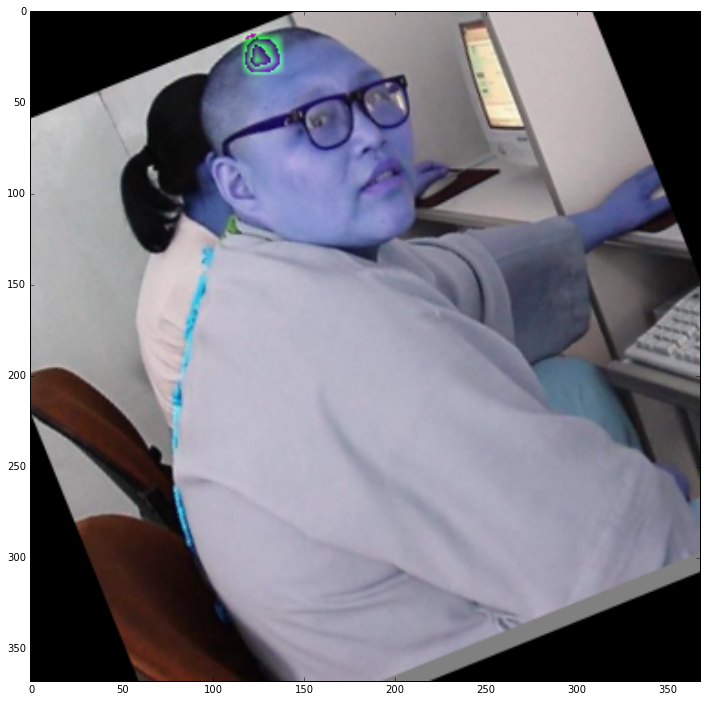

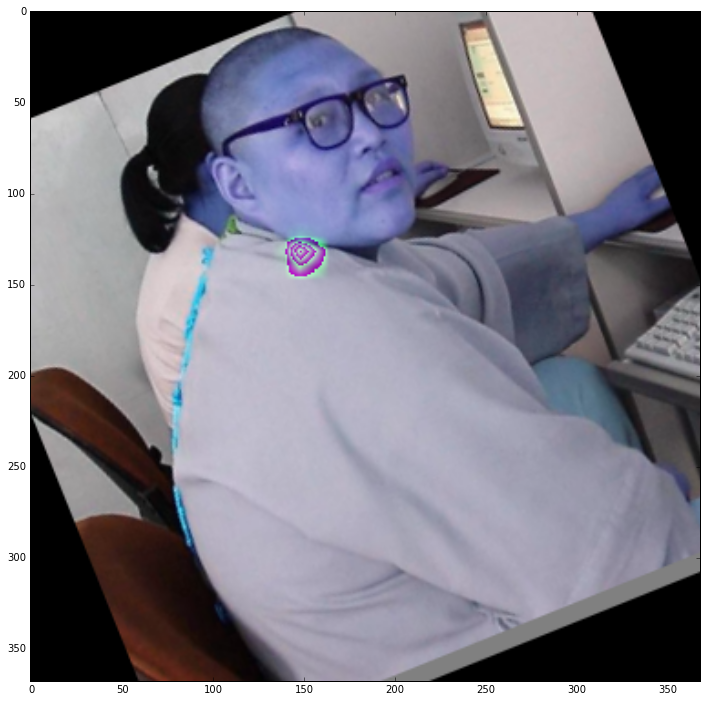

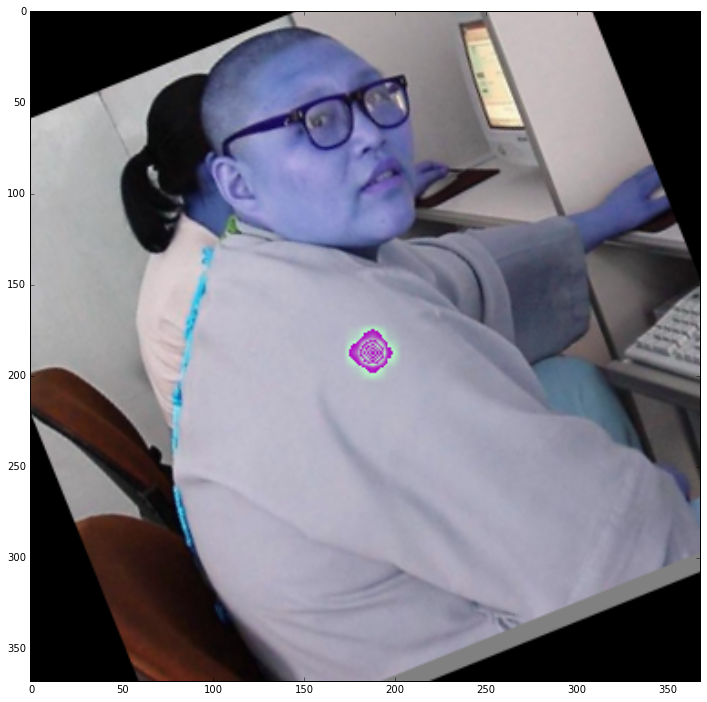

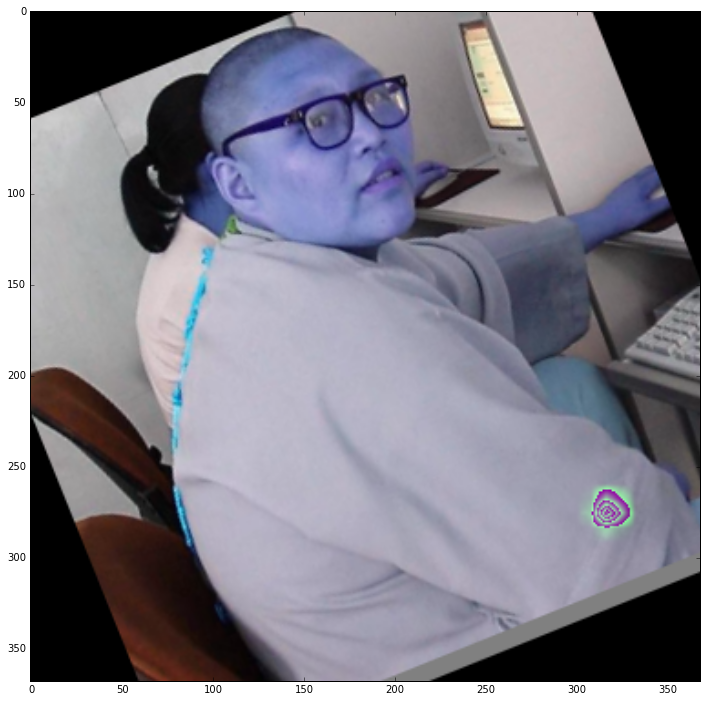

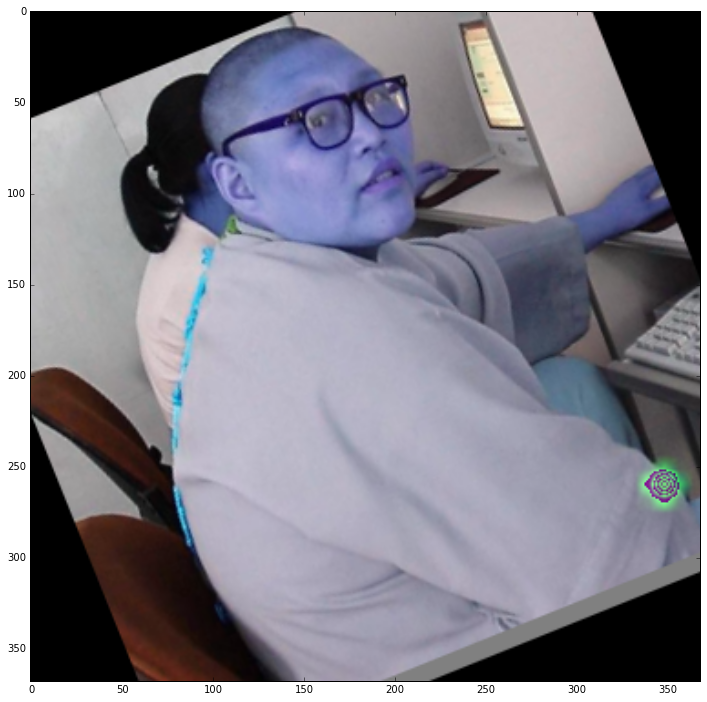

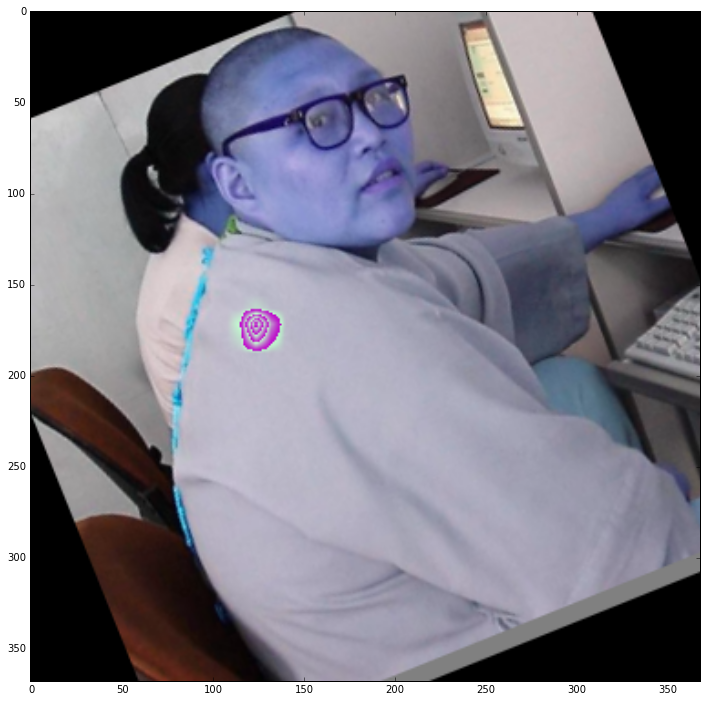

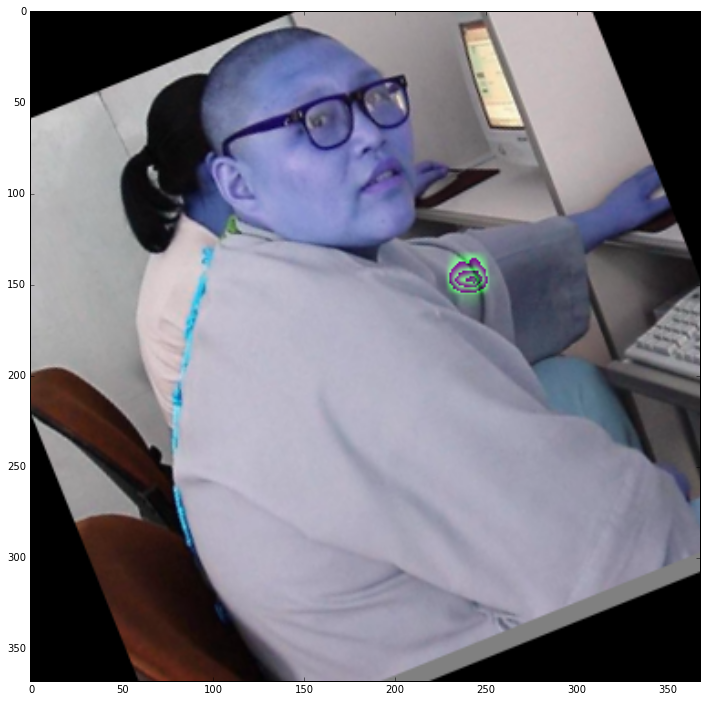

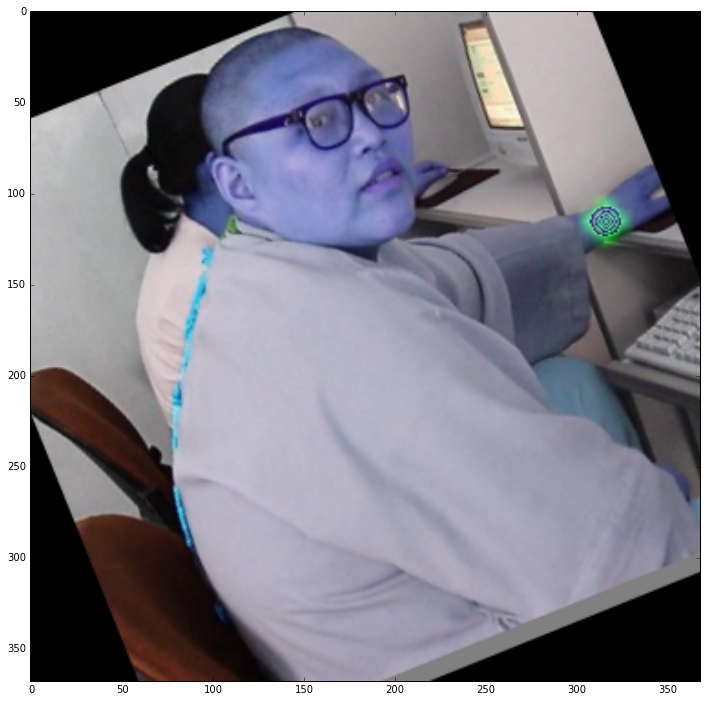

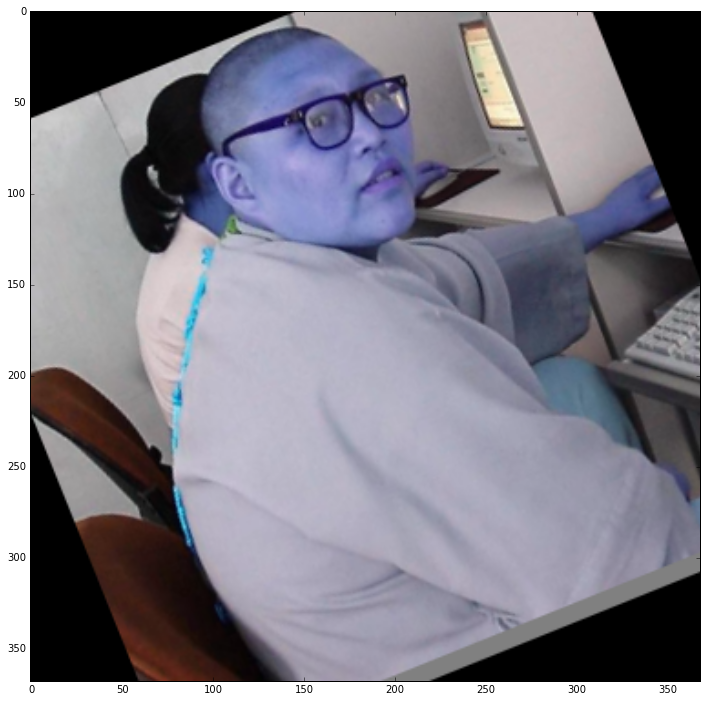

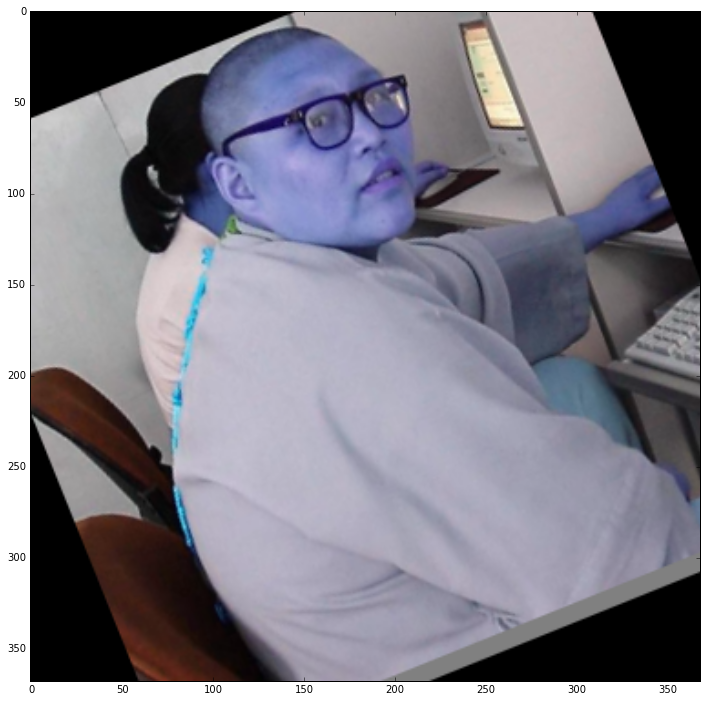

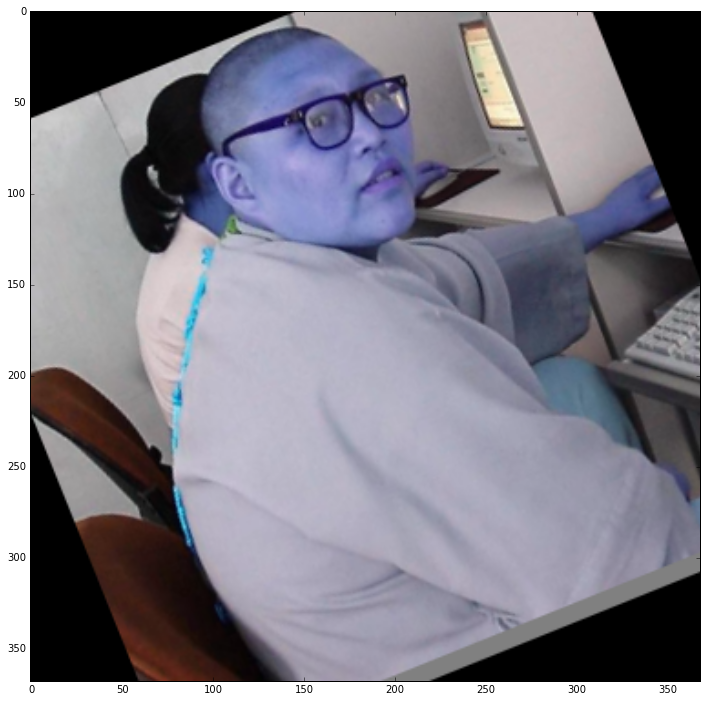

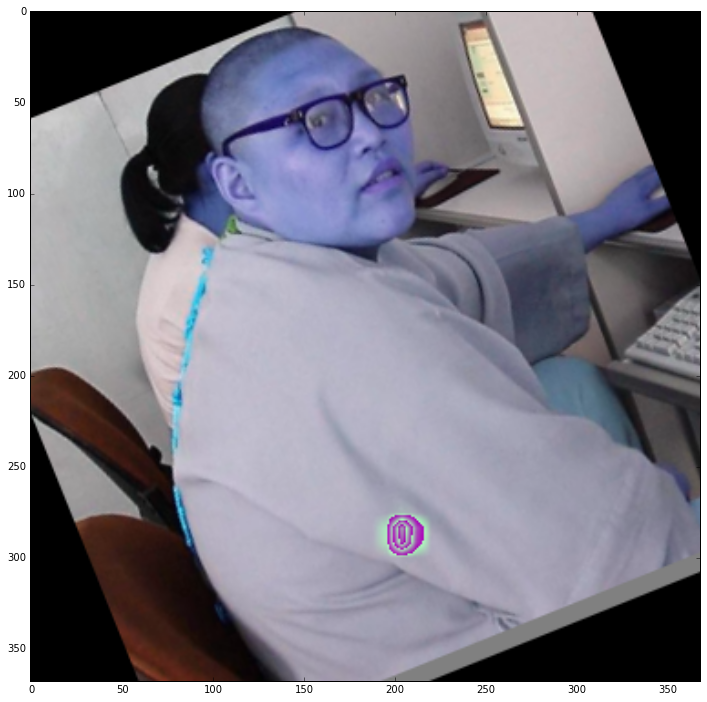

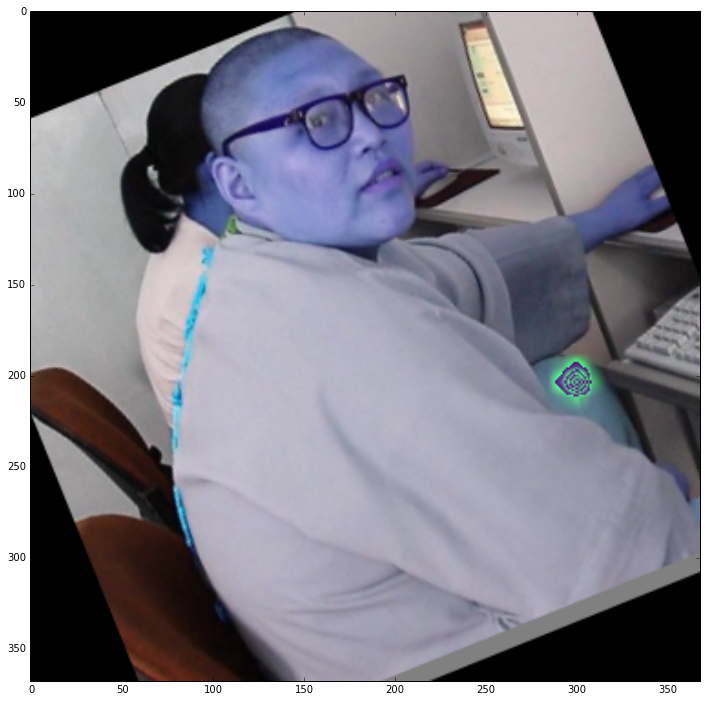

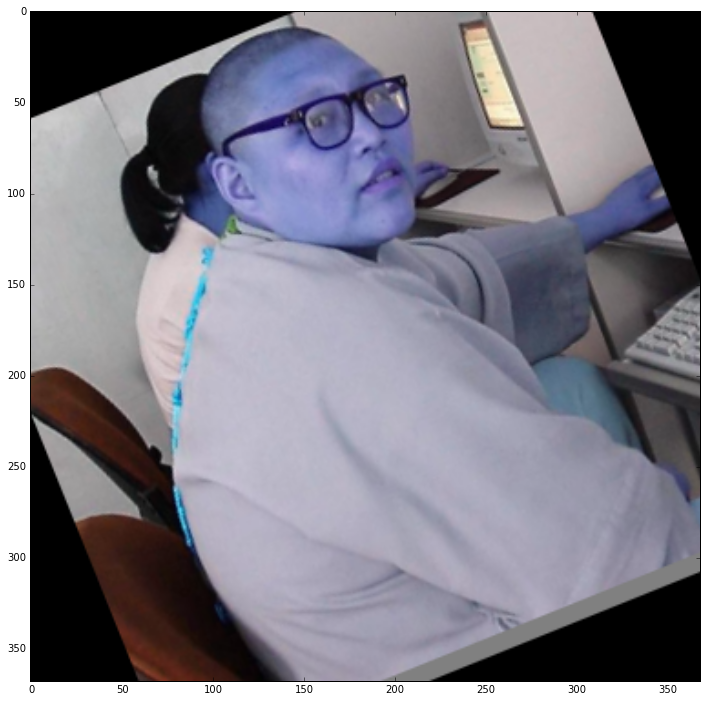

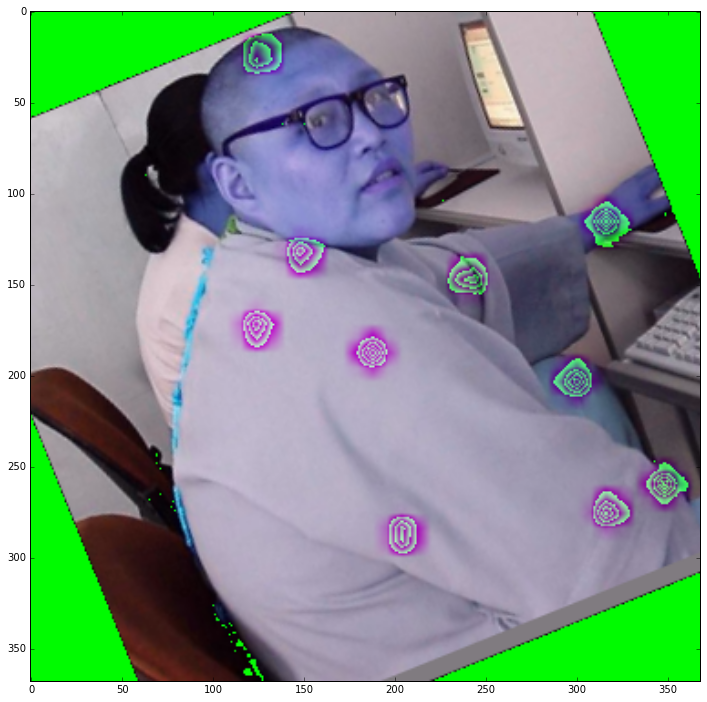

(46, 46)
(46L, 46L)


In [21]:
#!/usr/bin/python2
#encoding=utf-8
'''
Created on 2017年10月11日

@author: kohillyang
'''
# from __future__ import absolute_import
import sys,os,json,cv2,copy,sqlite3
import matplotlib.pyplot as plt

%matplotlib inline

from random import randint
import cPickle as pickle
import mxnet as mx
__file__="/data1/yks/mxnet_ai/ai_openpose/notebook_showdataset.py"
selfpathdir = os.path.dirname(__file__)
sys.path.append("/data1/yks/mxnet_ai/mxnet_pose_for_AI_challenger")
from generateLabelCPMWeight import getImageandLabel

import numpy as np
heatmap_index_map = [5,6,7,2,3,4,11,12,13,8,9,10,0,1,14]#14 means mean of all part
pafmap_index_map = []
'''
13 脖子
12 头顶 
11 右脚
10 右膝
9 右髋
8 左脚
7 左膝
6 左髋
5 右腕
4 右肘
3 右肩
2 左腕
1 左肘
0 左肩
'''
class Ai_data_set(object):
    class DataBatchweight(object):
        def __init__(self, data, heatmaplabel, partaffinityglabel, heatweight, vecweight, pad=0):
            self.data = [data]
            self.label = [heatmaplabel, partaffinityglabel, heatweight, vecweight]
            self.pad = pad
        
    def showdataset(self,image, heatmap, pagmap):
        # maskscale = mask[0:368:8, 0:368:8, 0]
        # print(mask.shape,maskscale.shape,heatmap[0].shape,pagmap[0].shape)
        heat = image.astype(np.float32) /255
        pag = image.astype(np.float32) /255
        plt.imshow(image)
        
        # cv2.imshow("mask",mask[:,:,1] * 255)
    
        print>>sys.stderr,len(heatmap),len(pagmap)
    
        for i in range(heatmap.shape[0]):
            heatmap_x = cv2.resize(heatmap[i],(image.shape[0],image.shape[1]),cv2.INTER_CUBIC)
            heat_c = copy.copy(heat)
            heat_c[:,:,1] = 1 * heat_c[:,:,1] + 5 * heatmap_x        
            #heat_c[:,:,1] /= np.max(heat_c[:,:,2])
            fig = plt.gcf()
            fig.set_size_inches(12, 12)
            ax1 = fig.add_subplot(1,1,1) 
            ax1.imshow(heat_c)
#         pagmap_x = cv2.resize(pagmap[i * 2],(image.shape[0],image.shape[1]),cv2.INTER_CUBIC)
#         pagmap_y = cv2.resize(pagmap[i * 2 + 1],(image.shape[0],image.shape[1]),cv2.INTER_CUBIC)
#         pag_c = copy.copy(pag)
#         pag_c[:,:,2] = 1 * pag_c[:,:,2] + np.sqrt(pagmap_x * pagmap_x + pagmap_y * pagmap_y )          
#         pag_c[:,:,2] /= np.max(pag_c[:,:,2])
#         cv2.imshow("pag",pag_c)
            plt.show()
    
        print(heatmap[0].shape)
        print(pagmap[0].shape)    
    @staticmethod
    def convertdataset2sqlite(pose_io_json_path,filename = "tmp2.db",maxcount = 40000):
        conn= sqlite3.connect(filename)
        cursor = conn.cursor()
        cursor.execute('''CREATE TABLE if not exists DB0
               (ID TEXT PRIMARY KEY     NOT NULL,
               DATA        BLOB);''')  
        data = json.load(open(pose_io_json_path,"rb"))
        print(len(data.keys()))
        count = 0
        for key in data:
            image, mask, heatmap, pagmap = getImageandLabel(data[key])
            v = pickle.dumps([image, mask, heatmap, pagmap]) 
            cursor.execute("INSERT INTO DB0(ID,DATA) VALUES ( ?, ? )" ,
                          (str(key),sqlite3.Binary(buffer(v)),)  
                        )
            count += 1
            print(count,len(data.keys()))
            if (count % 10)  == 0:
                conn.commit()  
            if (count > maxcount):
                return
    def __init__(self,batchsize,dbname = "ai_train_40000.db"):
        self.dbname = dbname
        self.batchsize = batchsize
        self.conn = sqlite3.connect(self.dbname)
        self.cursor = self.conn.cursor()        
        self.cursor.execute(' SELECT COUNT(*) FROM DB0 ')
        self.count = int(self.cursor.fetchone()[0])
    def __iter__(self):
        self.cur_batch = 0
        self.cursor.close()
        self.cursor = self.conn.cursor()        
        return self
    def __next__(self):
        r = []
        self.cursor.execute(' SELECT * FROM DB0 limit {0} OFFSET {1}'.format(self.batchsize,randint(0,self.count - 1 - self.batchsize)))
        transposeImage_batch = []
        heatmap_batch = []
        pagmap_batch = []
        heatweight_batch = []
        vecweight_batch = []
        for row in self.cursor:
            data  = row[1]
            r.append(pickle.loads(str(data)))            
            image, mask, heatmap, pagmap = pickle.loads(str(data))

            heatmap_new = [None] * len(heatmap)
            pagmap_new = [None] * len(heatmap)
            assert len(heatmap_index_map) == len(heatmap)
            for i in range(len(heatmap_index_map)):
                heatmap_new[heatmap_index_map[i]] = heatmap[i]
            heatmap = heatmap_new
            maskscale = mask[0:368:8, 0:368:8, 0]
           
            heatweight = np.repeat(maskscale[np.newaxis, :, :], len(heatmap), axis=0)
            vecweight  = np.repeat(maskscale[np.newaxis, :, :], len(pagmap), axis=0)
            
            transposeImage = np.transpose(np.float32(image), (2,0,1))/255 - 0.5
        
            self.cur_batch += 1
            
            transposeImage_batch.append(transposeImage)
            heatmap_batch.append(heatmap)
            pagmap_batch.append(pagmap)
            heatweight_batch.append(heatweight)
            vecweight_batch.append(vecweight)
            
        return Ai_data_set.DataBatchweight(
            mx.nd.array(transposeImage_batch),
            mx.nd.array(heatmap_batch),
            mx.nd.array(pagmap_batch),
            mx.nd.array(heatweight_batch),
            mx.nd.array(vecweight_batch))

    def next(self):
        return self.__next__()

if __name__ == "__main__":
    pose_io_json_path = os.path.join(selfpathdir,"../mxnet_pose_for_AI_challenger/pose_io/AI_data_val.json")
    # Ai_data_set.convertdataset2sqlite(pose_io_json_path)
    d = Ai_data_set(1)
    for da in d:
        images,heatmaplabels, partaffinityglabels, _,_ = da.data + da.label
        for image,heatmap,pafmap in zip(images,heatmaplabels,partaffinityglabels):
            image = image.asnumpy()
            heatmap = heatmap.asnumpy()
            image = (image +0.5) *255
            image = np.transpose(np.uint8(image), (1,2,0))
            print(heatmap.shape)
            d.showdataset(image,heatmap,pafmap)
        break




            